# Homework03 Pre-trained CNNs with Keras

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [27]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
LECTURE_ID = "HW03"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", LECTURE_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Use transfer learning for image classification, going through these steps:

- Use an existing TensorFlow Dataset. https://www.tensorflow.org/datasets

- Split it into a training set, a validation set, and a test set.

- Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.

- Fine-tune a pretrained model on this dataset (e.g., ResNet50 or VGG16). https://keras.io/api/applications/ 

- Use the fine-tuned model to predict the class of a batch of images from the test set. 

Hint: Use Google Colab

In [28]:
#modules
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models

In [29]:
#     Data preprocessing
# 1.  Use an existing TensorFlow Dataset. https://www.tensorflow.org/datasets
dataset = tfds.load("tf_flowers", as_supervised=True)

In [30]:
# 2.  Split it into a training set, a validation set, and a test set.
(train_ds, train_labels), (test_ds, test_labels ), (val_ds, val_labels) = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],batch_size=-1, as_supervised=True)

IMG_SIZE = 224

## Resizing images
train_ds = tf.image.resize(train_ds, (IMG_SIZE, IMG_SIZE))
test_ds = tf.image.resize(test_ds, (IMG_SIZE, IMG_SIZE))
val_ds = tf.image.resize(val_ds, (IMG_SIZE, IMG_SIZE))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)
val_labels = to_categorical(val_labels, num_classes=5)

In [111]:
## Data augmention
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  #layers.RandomRotation(0.01),
])

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds) 
val_ds = preprocess_input(val_ds) 

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [112]:
# new Layer
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

#Input 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 75, 75, 16)
#regularization_layer = tf.keras.layers.Dense(5, kernel_initializer='ones',
#                              kernel_regularizer=tf.keras.regularizers.l1(0.01),
#                              activity_regularizer=tf.keras.regularizers.l2(0.01))

tf.random.set_seed(0)
#dropout_layer = tf.keras.layers.Dropout(.2, input_shape=(2,))



In [113]:
# Define model
model = models.Sequential([
    data_augmentation,
    #layers.Conv2D(16, 3, padding='same', activation='relu'),
    #layers.MaxPooling2D(),
    base_model,
    #dropout_layer,
    #regularization_layer,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])



In [114]:
# Fine tune
#base_model.trainable = True
# Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
#fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#    layer.trainable =  False

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)


In [115]:
# Model summary
model.build((None, IMG_SIZE, IMG_SIZE, 3)) 
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_24 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_31 (Dense)            (None, 50)                1254450   
                                                                 
 dense_32 (Dense)            (None, 20)                1020      
                                                                 
 dense_33 (Dense)            (None, 5)                 105       
                                                                 
Total params: 15,970,263
Trainable params: 1,255,575


In [116]:
history_fine = model.fit(train_ds, train_labels, epochs=30, validation_data=(val_ds, val_labels), batch_size=32, callbacks=[es])

Epoch 1/30
81/81 [==============================] - 6s 70ms/step - loss: 6.8345 - accuracy: 0.4488 - val_loss: 4.9742 - val_accuracy: 0.5309
Epoch 2/30
81/81 [==============================] - 5s 63ms/step - loss: 2.3585 - accuracy: 0.6057 - val_loss: 4.9943 - val_accuracy: 0.5109
Epoch 3/30
81/81 [==============================] - 5s 62ms/step - loss: 1.5926 - accuracy: 0.6715 - val_loss: 3.4295 - val_accuracy: 0.4982
Epoch 4/30
81/81 [==============================] - 5s 63ms/step - loss: 1.1495 - accuracy: 0.7018 - val_loss: 2.6792 - val_accuracy: 0.4945
Epoch 5/30
81/81 [==============================] - 5s 64ms/step - loss: 0.8800 - accuracy: 0.7408 - val_loss: 2.9468 - val_accuracy: 0.5345
Epoch 6/30
81/81 [==============================] - 5s 64ms/step - loss: 0.7379 - accuracy: 0.7583 - val_loss: 3.3328 - val_accuracy: 0.5364
Epoch 7/30
81/81 [==============================] - 5s 64ms/step - loss: 0.6090 - accuracy: 0.7953 - val_loss: 3.4104 - val_accuracy: 0.5400
Epoch 8/30
81

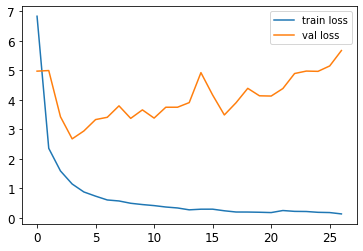

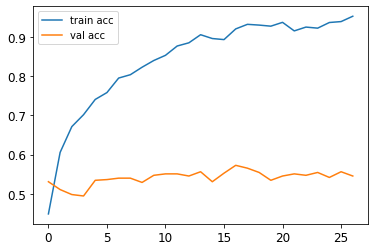

In [117]:
# Eval loss
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# Eval accuracies
plt.plot(history_fine.history['accuracy'], label='train acc')
plt.plot(history_fine.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [118]:
model.evaluate(test_ds, test_labels)

18/18 [==============================] - 1s 46ms/step - loss: 3.6223 - accuracy: 0.5862


[3.62229585647583, 0.5862069129943848]